<a href="https://colab.research.google.com/github/arielwendichansky/SoundFlow/blob/main/Sound_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Based on Data Provided by Spotify, several analysis were performed with different goals.
    1. Where are most artists originally from that have music within our dataset?
    2. How did the distribution of musical features change through out the years?
    2. Is there a trend noticible regarding the release date of tracks? If what could be a reason for that.
    3. Are certain musical features correlated?
    4. What musical features have a high correlation to the number of streams? Can we predict successful songs based on these discovered features?

- The data optained through the Kaggle API, is saved within a PostgreSQL online database, Elephant. Initially two tables were created. One in which the raw data is saved and another that includes only the artist name and country of origin.

- During the exploratory analysis, it was discovered that the number of tracks per release year was strongly unbalanced. Therefore the decision was made to optain further data which was saved in a separate table within the database, and then joined using SQL for an enriched analysis process.

- For efficiant data processing, best practice and principles,the project is built on OOP. All classes are saved within separate .py files and then imported straight from the Git repo to be called in this notebook. These modules include preprocessing - a class for cleaning the data like droping columns, droping null values, outlier detection and removal, replacement of values, etc. The Managedb class allows to connect to our database, upload and query data. Finally, a plotting class was created that allows the user to interactivly select the type of plot they want displayed, as well as the column names to be displayed. Title and axis labels can also be specified.  


# Data Dictionary

ADD VARIABLE NAMES AND DISCRIPTIONS

# REQUIREMENTS

In [1]:
#!pip install psycopg2-binary
#!wget https://raw.githubusercontent.com/arielwendichansky/SoundFlow/main/preprocessing.py
#!wget https://raw.githubusercontent.com/arielwendichansky/SoundFlow/main/2nd_batch_month.JSON
#!wget https://raw.githubusercontent.com/arielwendichansky/SoundFlow/main/artist_country.json
#!wget https://raw.githubusercontent.com/arielwendichansky/SoundFlow/main/Managedb.py
!wget https://raw.githubusercontent.com/arielwendichansky/SoundFlow/main/Plotting.py


--2024-04-06 18:47:13--  https://raw.githubusercontent.com/arielwendichansky/SoundFlow/main/Plotting.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4882 (4.8K) [text/plain]
Saving to: ‘Plotting.py’

Plotting.py         100%[===================>]   4.77K  --.-KB/s    in 0s      

2024-04-06 18:47:13 (42.3 MB/s) - ‘Plotting.py’ saved [4882/4882]



In [2]:
from preprocessing import pregame #own class
from Managedb import ManageDatabase #own class
from Plotting import Plotting #own class
import pandas as pd
import psycopg2 #for database connection
import urllib.parse as up
import json
import plotly.express as px
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

#Extracting data Kaggle and creating data - only to show where we took it from

In [ ]:
! pip install -k kaggle

In [ ]:

files.upload()

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d nelgiriyewithana/top-spotify-songs-2023
! unzip 'top-spotify-songs-2023.zip'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
top-spotify-songs-2023.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  top-spotify-songs-2023.zip
replace spotify-2023.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
! kaggle datasets download -d leonardopena/top-spotify-songs-from-20102019-by-year

top-spotify-songs-from-20102019-by-year.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
! unzip 'top-spotify-songs-from-20102019-by-year.zip'

Archive:  top-spotify-songs-from-20102019-by-year.zip
replace top10s.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [29]:
df = pd.read_csv("top10s.csv", encoding='ISO-8859-1')
df.head()

,Unnamed: 0,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


In [30]:
df=df.drop(columns=['top genre'])
df.drop("Unnamed: 0", axis=1, inplace=True)

In [26]:
with open('2nd_batch_month.JSON', 'r') as file:
    data = json.load(file)

# DATABASE MANAGEMENT

In [31]:
#creating objects for connection to db with different files
raw_data_2010_2019 = ManageDatabase(df)

artists = ManageDatabase('artist_df')

songs = ManageDatabase('df')

In [6]:
#calling method to get artist and country data
artist_raw_df = artists.query_table("artist_data")

#calling method to query data by track (data including years 21,22,23)
songs_raw_df = songs.query_table('main_music_data')

#calling method to query additional data (up to year 19)
old_songs = raw_data_2010_2019.query_table('raw_data_2010_2019')


In [15]:
#calling method to upload data to db

#ONLY UNCOMMENT WHEN WANTING TO UPLOAD DATA TO DB
#raw_data_2010_2019.upload_to_db('raw_data_2010_2019')

In [7]:
# Merge the two DataFrames on common columns
merged_df = pd.merge(songs_raw_df, old_songs, on=['track_name', 'artist_name', 'released_year', 'bpm', 'energy',
                                   'danceability', 'liveness', 'valence', 'acousticness',
                                   'speechiness', 'released_month'], how='outer')

merged_df.tail()

,track_name,artist_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,decibel,dur,popularity
1549,Find U Again (feat. Camila Cabello),Mark Ronson,NaN,2019,6,NaN,NaN,NaN,NaN,NaN,...,61,16,66,1,NaN,20,3,-7.0,176.0,75.0
1550,Cross Me (feat. Chance the Rapper & PnB Rock),Ed Sheeran,NaN,2019,12,NaN,NaN,NaN,NaN,NaN,...,75,61,79,21,NaN,7,12,-6.0,206.0,75.0
1551,"No Brainer (feat. Justin Bieber, Chance the Ra...",DJ Khaled,NaN,2019,7,NaN,NaN,NaN,NaN,NaN,...,53,65,76,7,NaN,9,34,-5.0,260.0,70.0
1552,Nothing Breaks Like a Heart (feat. Miley Cyrus),Mark Ronson,NaN,2019,1,NaN,NaN,NaN,NaN,NaN,...,60,24,79,1,NaN,42,7,-6.0,217.0,69.0
1553,Kills You Slowly,The Chainsmokers,NaN,2019,4,NaN,NaN,NaN,NaN,NaN,...,70,23,44,6,NaN,13,6,-9.0,213.0,67.0


In [8]:
columns_to_drop = ['artist_count', 'released_day', 'in_spotify_playlists',
                   'in_spotify_charts','mode', 'streams', 'in_apple_playlists',
                   'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts',
                   'decibel', 'dur', 'popularity', 'instrumentalness']

merged_df = merged_df.drop(columns=columns_to_drop)

In [33]:
merged_df.isnull().sum()

track_name        0
artist_name       0
released_year     0
released_month    0
bpm               0
danceability      0
valence           0
energy            0
acousticness      0
liveness          0
speechiness       0
dtype: int64

In [ ]:
#Uploading new dataframe to database
#DON'T UNCOMMENT UNLESS WANT TO ADD DATA TO TABLE AGAIN

#merged = ManageDatabase(merged_df)
#merged.upload_to_db('songs_record')

# PREPROCESSING

In [34]:
df_month = pd.DataFrame(list(data.items()), columns=['title', 'released_month'])

# Display the DataFrame
print(df_month)

                                                 title  released_month
0                                     Hey, Soul Sister               8
1                                 Love The Way You Lie               6
2                                              TiK ToK               1
3                                          Bad Romance              10
4                                 Just the Way You Are               7
..                                                 ...             ...
578                Find U Again (feat. Camila Cabello)               6
579      Cross Me (feat. Chance the Rapper & PnB Rock)              12
580  No Brainer (feat. Justin Bieber, Chance the Ra...               7
581    Nothing Breaks Like a Heart (feat. Miley Cyrus)               1
582                                   Kills You Slowly               4

[583 rows x 2 columns]


In [35]:
# Create a dictionary mapping song titles to release months
title_to_month = df_month.set_index('title')['released_month'].to_dict()

# Map the song titles in df to their release months using the dictionary
df['released_month'] = df['title'].map(title_to_month)

# Display the updated DataFrame
print(df)

                                                 title            artist  \
0                                     Hey, Soul Sister             Train   
1                                 Love The Way You Lie            Eminem   
2                                              TiK ToK             Kesha   
3                                          Bad Romance         Lady Gaga   
4                                 Just the Way You Are        Bruno Mars   
..                                                 ...               ...   
598                Find U Again (feat. Camila Cabello)       Mark Ronson   
599      Cross Me (feat. Chance the Rapper & PnB Rock)        Ed Sheeran   
600  No Brainer (feat. Justin Bieber, Chance the Ra...         DJ Khaled   
601    Nothing Breaks Like a Heart (feat. Miley Cyrus)       Mark Ronson   
602                                   Kills You Slowly  The Chainsmokers   

     year  bpm  nrgy  dnce  dB  live  val  dur  acous  spch  pop  \
0    2010   97    8

We realize that in our dataset we don't have the information where's the singer from, so we created these data as artist_country


In [36]:
df.isna().sum()

title             0
artist            0
year              0
bpm               0
nrgy              0
dnce              0
dB                0
live              0
val               0
dur               0
acous             0
spch              0
pop               0
released_month    5
dtype: int64

In [38]:
#filling missing values with mean
df['released_month'].fillna(df['released_month'].mean(),inplace=True) #could do this with pre

In [39]:
#Converting the 'released_month' column to integers
df['released_month'] = df['released_month'].astype(int)

print(df)

                                                 title            artist  \
0                                     Hey, Soul Sister             Train   
1                                 Love The Way You Lie            Eminem   
2                                              TiK ToK             Kesha   
3                                          Bad Romance         Lady Gaga   
4                                 Just the Way You Are        Bruno Mars   
..                                                 ...               ...   
598                Find U Again (feat. Camila Cabello)       Mark Ronson   
599      Cross Me (feat. Chance the Rapper & PnB Rock)        Ed Sheeran   
600  No Brainer (feat. Justin Bieber, Chance the Ra...         DJ Khaled   
601    Nothing Breaks Like a Heart (feat. Miley Cyrus)       Mark Ronson   
602                                   Kills You Slowly  The Chainsmokers   

     year  bpm  nrgy  dnce  dB  live  val  dur  acous  spch  pop  \
0    2010   97    8

In [40]:
df.columns = ['track_name', 'artist_name', 'released_year', 'bpm', 'energy', 'danceability', 'decibel', 'liveness', 'valence',
       'dur', 'acousticness', 'speechiness', 'popularity', 'released_month']

In [41]:
#creating object for preprocessing the data queried previously
artist_df = pregame(artist_raw_df)
#calling method for initial data checks
artist_df.checks()

INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394 entries, 0 to 1393
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist_name  1394 non-null   object
 1   country      1394 non-null   object
dtypes: object(2)
memory usage: 21.9+ KB
None
DESCRIPTION: 
       artist_name        country
count         1394           1394
unique         697             47
top          Latto  United States
freq             2            446
NULL VALUE COUNT: 
artist_name    0
country        0
dtype: int64
DUPLICATE COUNT:  697
duplicates dropped


In [42]:
#creating object for preprocessing the data queried previously
songs_df = pregame(songs_raw_df)
#calling method for initial data checks
songs_df.checks()

INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   artist_name           953 non-null    object 
 2   artist_count          953 non-null    int64  
 3   released_year         953 non-null    int64  
 4   released_month        953 non-null    int64  
 5   released_day          953 non-null    int64  
 6   in_spotify_playlists  953 non-null    int64  
 7   in_spotify_charts     953 non-null    int64  
 8   streams               952 non-null    float64
 9   in_apple_playlists    953 non-null    int64  
 10  in_apple_charts       953 non-null    int64  
 11  in_deezer_playlists   953 non-null    object 
 12  in_deezer_charts      953 non-null    int64  
 13  bpm                   953 non-null    int64  
 14  mode                  953 non-null    object 
 15  danceability    

In [43]:
cdata = songs_raw_df.copy()

# Exploratory Analysis

In [44]:
#creating object for flexible plotting
plot = Plotting(cdata)

Available plot options:
1. Violin Plot
2. Histogram
3. Correlation Heatmap
4. Choropleth Map
5. Line Plot
Enter the number of the plot you want to create: 2


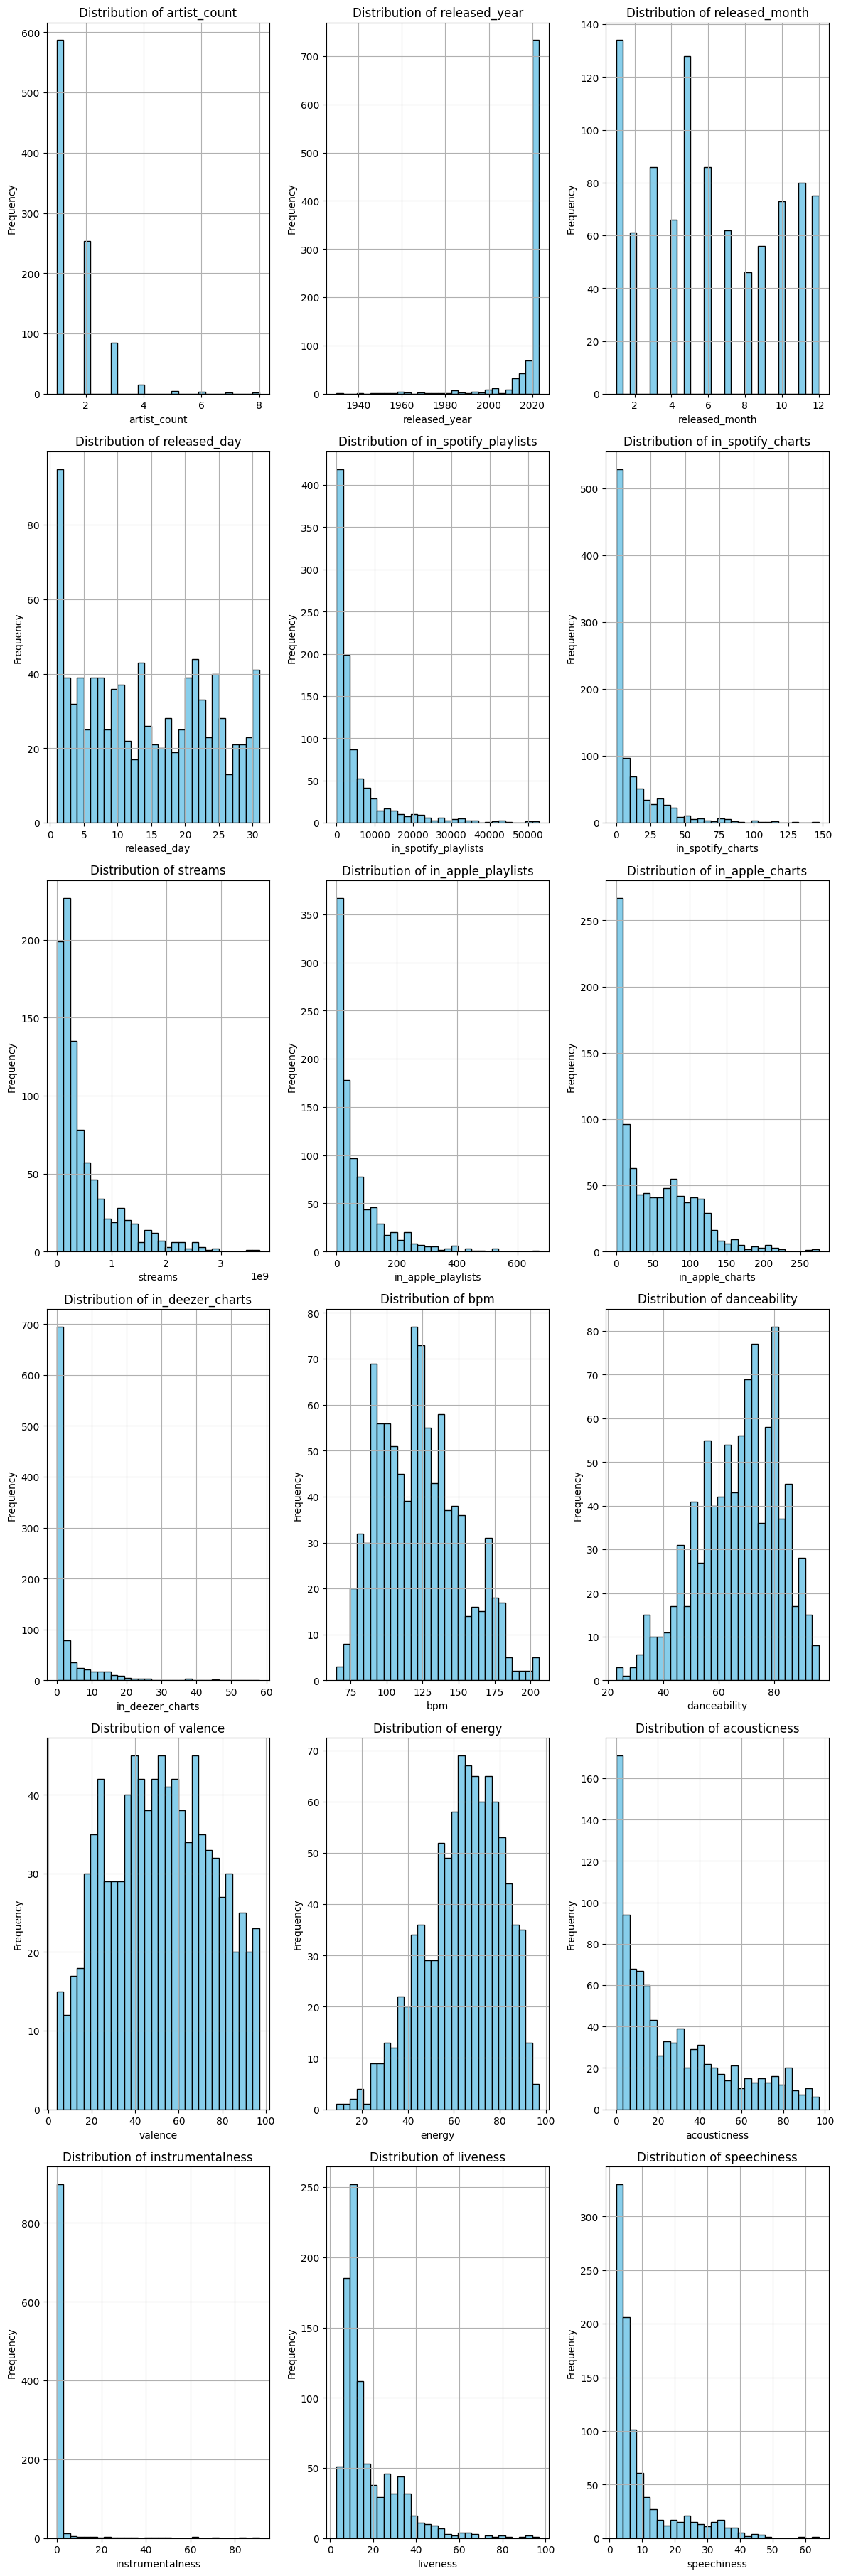

In [28]:
#calling method for interactive users choice of plot
plot.select_plot()

Available plot options:
1. Violin Plot
2. Histogram
3. Correlation Heatmap
4. Choropleth Map
5. Line Plot
Enter the number of the plot you want to create: 1
Enter the columns to plot (comma-separated, no space): bpm,danceability,valence,energy,acousticness,liveness,speechiness
Enter the title for the plot: Density Plot
Enter the xlabel for the plot: Musical Features
Enter the ylabel for the plot: Frequency


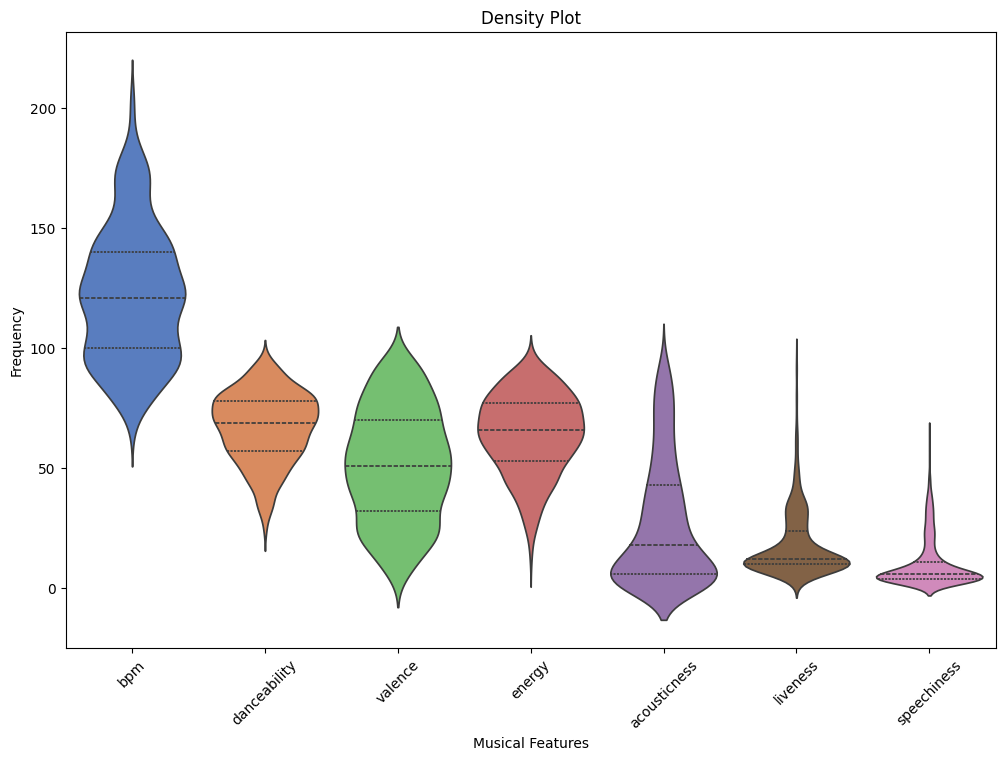

In [13]:
plot.select_plot()

Available plot options:
1. Violin Plot
2. Histogram
3. Correlation Heatmap
4. Choropleth Map
5. Line Plot
Enter the number of the plot you want to create: 1
Enter the columns to plot (comma-separated, no space): streams
Enter the title for the plot: Frequency of number of Streams
Enter the xlabel for the plot:  
Enter the ylabel for the plot: Frequency Streams


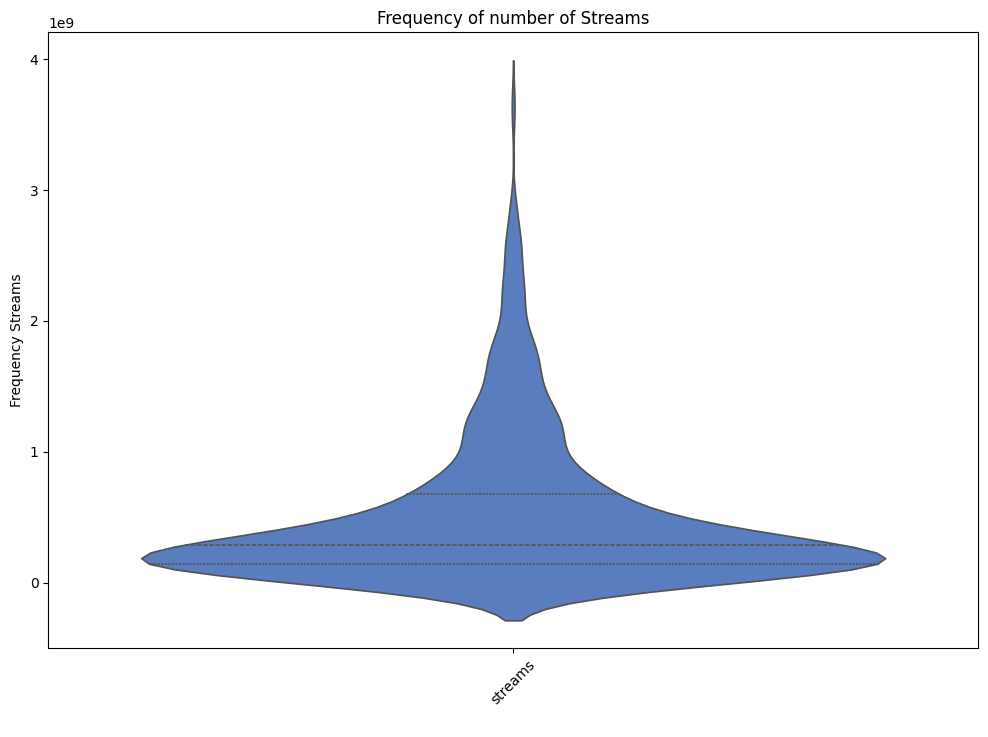

In [24]:
plot.select_plot()

The violin plot showing the number of streams shows that there are only a few tracks with exceptionally high number of streams. These are the songs we will be considering as the most succesfull. Following we will try to figure out what these tracks have in common to possibly predict what makes a successful song.

Available plot options:
1. Violin Plot
2. Histogram
3. Correlation Heatmap
4. Choropleth Map
5. Line Plot
Enter the number of the plot you want to create: 3
Do you want the corr of all or of specific columns? [1 = All, 2 = Specific]1


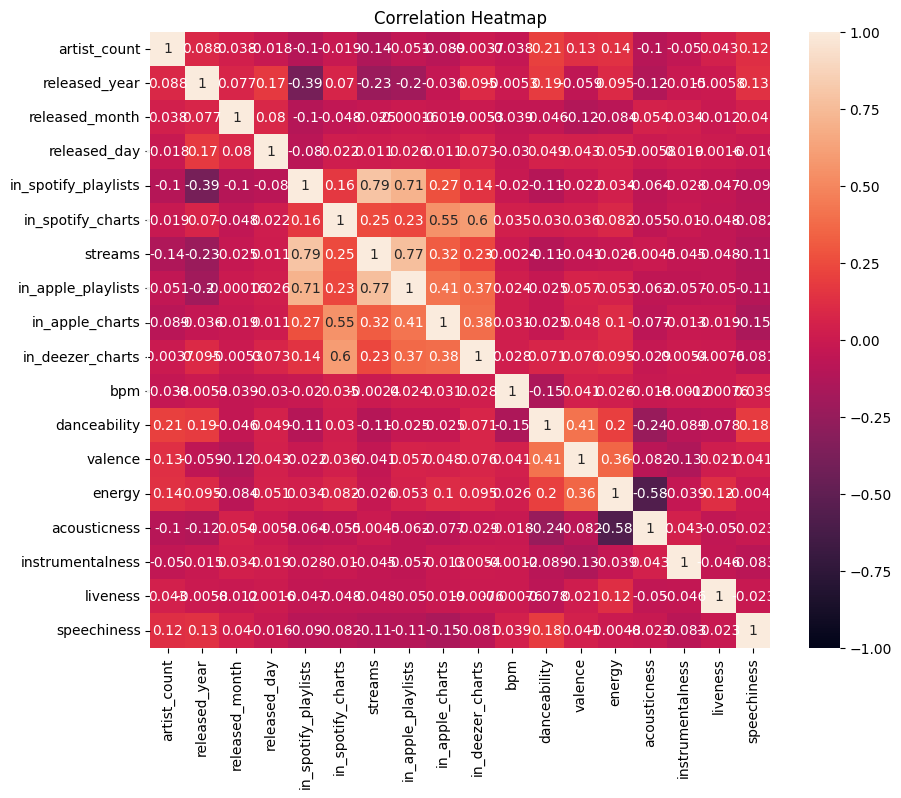

In [25]:
#checking correlation of all features
plot.select_plot()

Available plot options:
1. Violin Plot
2. Histogram
3. Correlation Heatmap
4. Choropleth Map
5. Line Plot
Enter the number of the plot you want to create: 3
Do you want the corr of all or of specific columns? [1 = All, 2 = Specific]2
Enter the columns for correlation of interest (comma-separated, no space): bpm,danceability,valence,energy,acousticness,liveness,speechiness


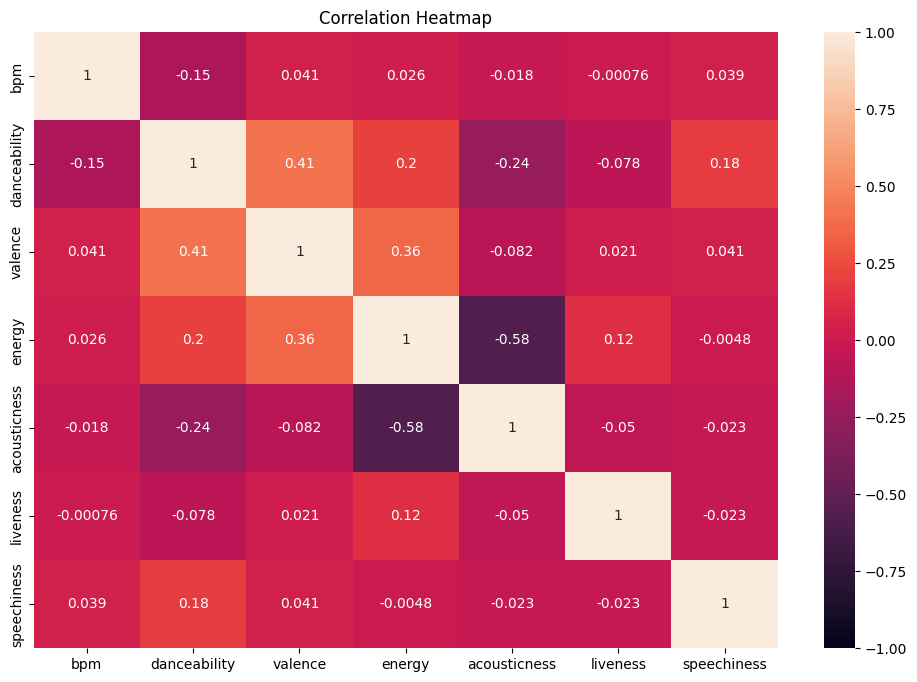

In [12]:
# heatmap of specific values
plot.select_plot()

# Artist country of origin

In [45]:
country_count = artist_raw_df.groupby("country")["artist_name"].count().reset_index(name = "count")
country_count.head()

,country,count
0,Argentina,34
1,Armenia,2
2,Australia,20
3,Austria,2
4,Barbados,4


In [16]:
geo_plot = Plotting(country_count)
geo_plot.plot_choropleth()

In [17]:
fig = px.choropleth(country_count,
                    locations='country',
                    locationmode='country names',
                    color='count',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='artist distribution by country',
                    range_color=(0, 80))
fig.show()

# Song Characteristics change of the years

<ipython-input-18-51d2779a7ed1>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




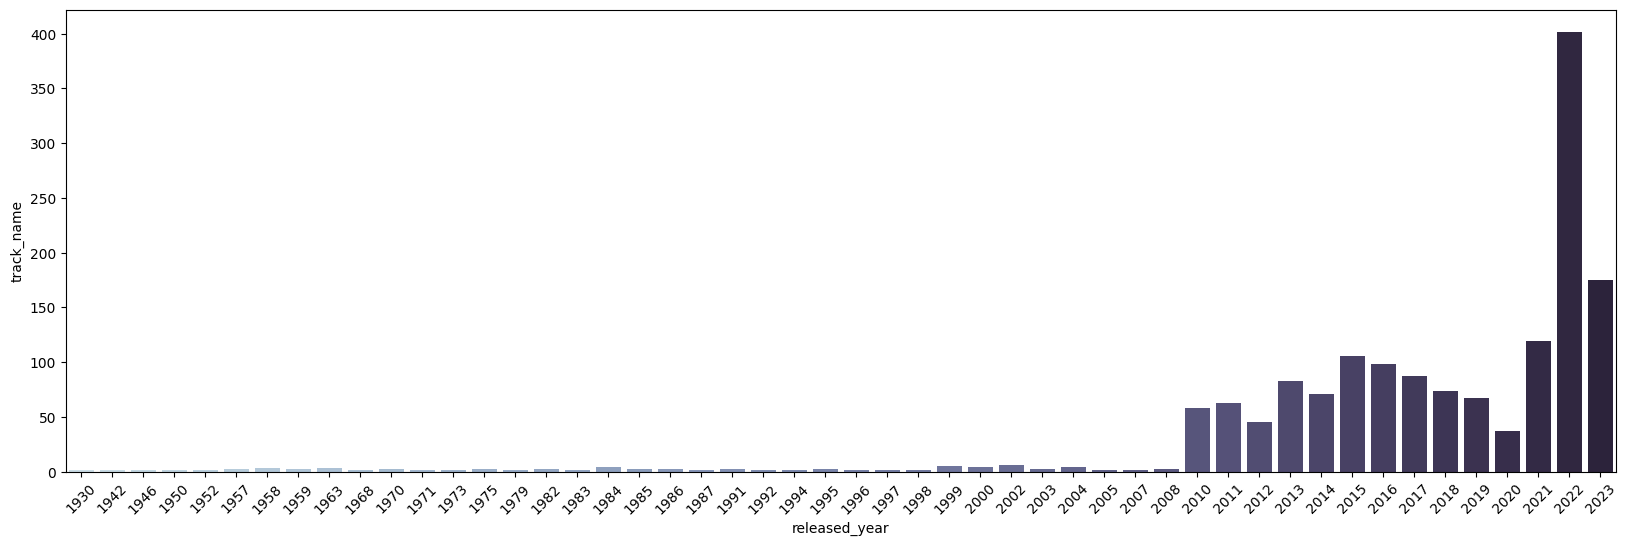

In [18]:
song_year = merged_df.groupby(merged_df['released_year']).count()
plt.figure(figsize=(20, 6))
sns.barplot(x=song_year.index, y=song_year['track_name'], data=song_year, palette='ch:s=.25,rot=-.25')
plt.xticks(rotation = 45)
plt.show()

We have lots of individual songs in the years before 2010. To balance out the data, all the years prior to 2010 are droped.

In [46]:
merged_df = merged_df[merged_df['released_year']>= 2010]

<ipython-input-91-676eee2abbee>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



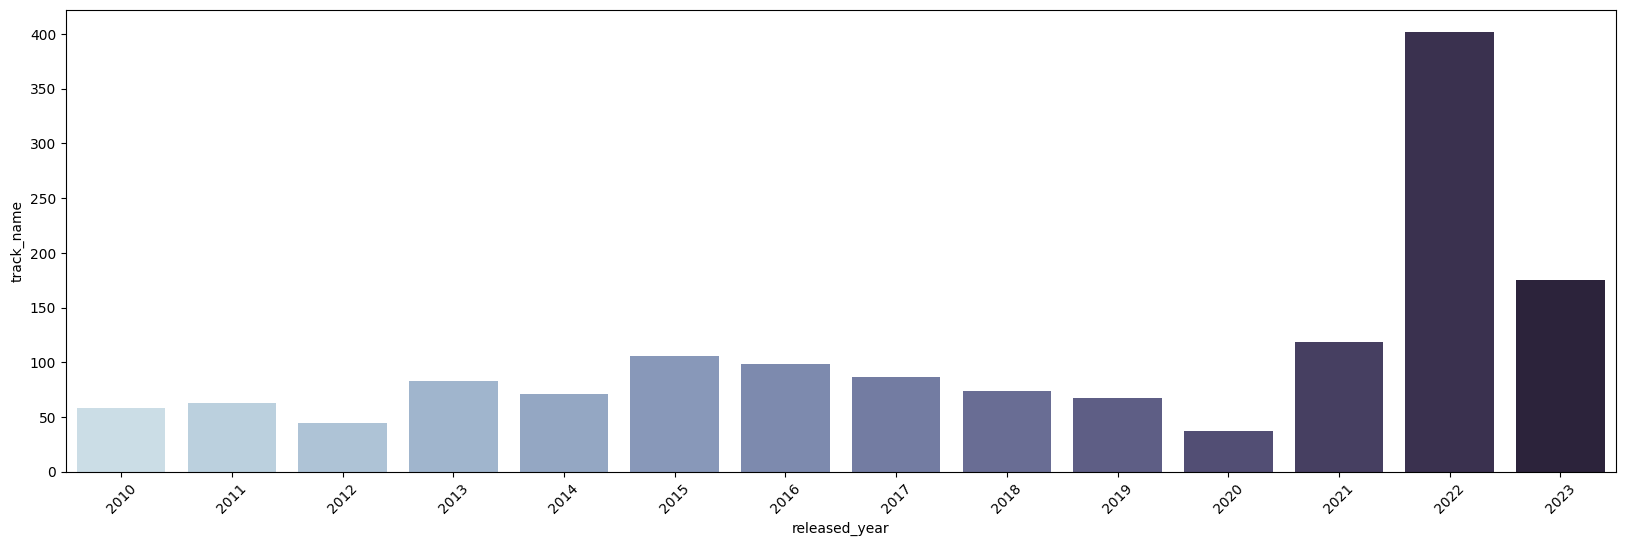

In [91]:
df_recent_years_grouped = merged_df.groupby(merged_df['released_year']).count()
plt.figure(figsize=(20, 6))
sns.barplot(x=df_recent_years_grouped.index, y=df_recent_years_grouped['track_name'], data=df_recent_years_grouped, palette='ch:s=.25,rot=-.25')
plt.xticks(rotation = 45)
plt.show()

The data still seams a little unbalanced since 2022 had exceptional high number of released songs. One reason could be due to the COVID-19 pandemic where restrictions were at its peak in 2020, less songs were able to be produced. The cancellation of festivals and concerts was still relevant in 2021. Therefore, the high number of songs released in 2022 could have been the many songs in piplenes that could finally be produced after the loosening of covid restrictions.

<ipython-input-92-b646181858f9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



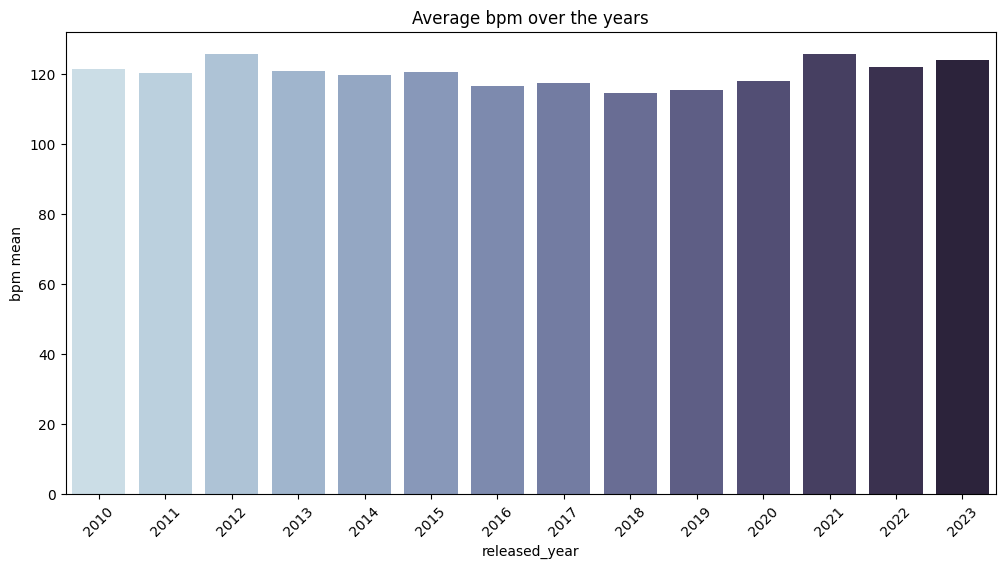

In [92]:
df_years_bpm = merged_df.groupby("released_year")["bpm"].mean().reset_index(name = "bpm mean")
plt.figure(figsize = (12, 6))
sns.barplot(x="released_year", y = "bpm mean", data = df_years_bpm, palette = "ch:s=.25,rot=-.25")
plt.title("Average bpm over the years")
plt.xticks(rotation = 45)
plt.show()

In [47]:
df_years_dance = merged_df.groupby("released_year")["danceability"].mean().reset_index(name = "danceability mean")

<ipython-input-94-5c7312496288>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



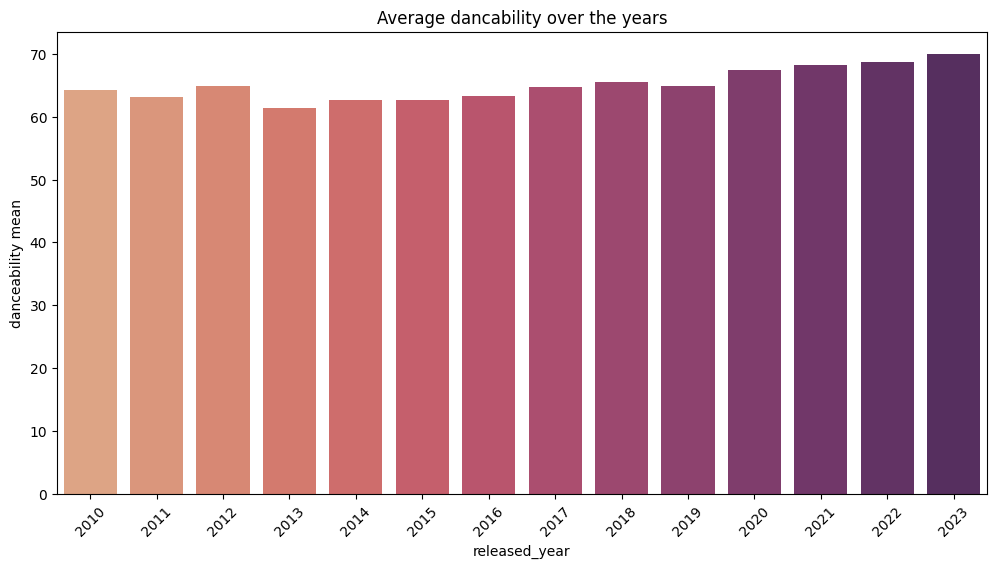

In [94]:
plt.figure(figsize = (12, 6))
sns.barplot(x="released_year", y = "danceability mean", data = df_years_dance, palette = "flare")
plt.title("Average dancability over the years")
plt.xticks(rotation = 45)
plt.show()

<ipython-input-95-b4ea19c195ab>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



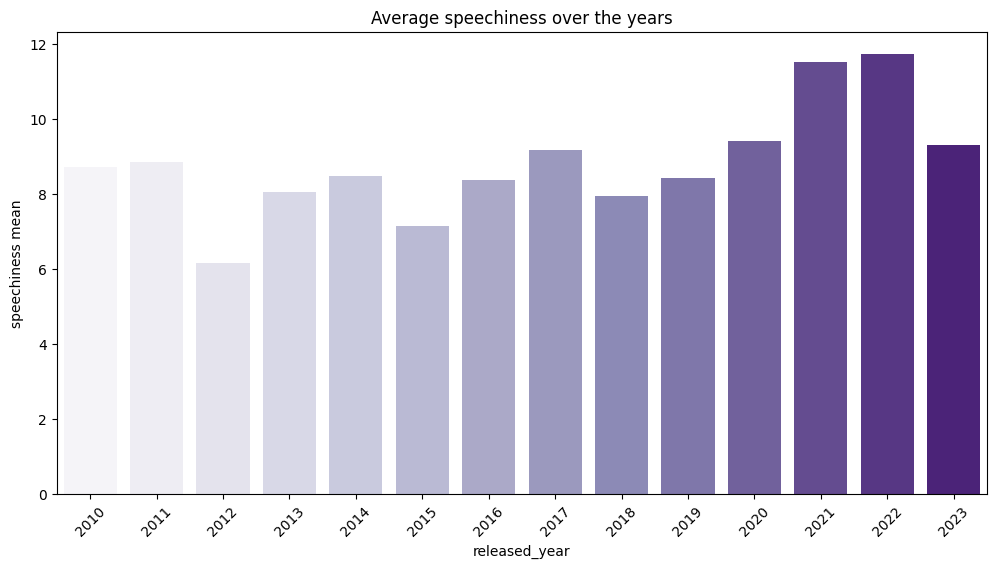

In [95]:
df_years_speach = merged_df.groupby("released_year")["speechiness"].mean().reset_index(name = "speechiness mean")
plt.figure(figsize = (12, 6))
sns.barplot(x="released_year", y = "speechiness mean", data = df_years_speach, palette = "Purples")
plt.title("Average speechiness over the years")
plt.xticks(rotation = 45)
plt.show()

Findings:
- BPM stayed stable
- Dancability increaed slightly
- Speechiness peaked in 2021 & 2022 and fell in 2023

Conclusions:
- The closure of live music venues and cancellation of concerts and tours due to the pandemic may have prompted artists to explore alternative ways of engaging with their audience.
- Significant changes in daily life, including concerns about health, social distancing measures, economic challenges, and social justice issues may have influenced the lyrical content of music, with artists incorporating spoken-word elements to address topics such as resilience, solidarity, unity, and the human experience during challenging times.

# Top 10 songs
#### What do these tracks have in common?
#### What made them successfull?

In [54]:
old_songs

In [55]:
#old_songs = old_songs.groupby('released_year')
def top_10_by_year(group):
    return group.nlargest(10, 'popularity')

In [22]:
top_10_songs_2010_2019 = pd.concat([top_10_by_year(group) for _, group in old_songs])

In [57]:
new_songs = songs_raw_df
new_songs = new_songs[new_songs['released_year']>=2020]
new_songs = new_songs.groupby('released_year')
def top_10_by_year(group):
    return group.nlargest(10, 'streams')

In [58]:
top_10_songs_2020_2023 = pd.concat([top_10_by_year(group) for _, group in new_songs])

In [59]:
# Merge the two DataFrames on common columns
top_10 = pd.merge(top_10_songs_2020_2023, top_10_songs_2010_2019, on=['track_name', 'artist_name', 'released_year', 'bpm', 'energy',
                                                                      'danceability', 'liveness', 'valence', 'acousticness',
                                                                      'speechiness', 'released_month'], how='outer')
top_10 = top_10.sort_values(by='released_year',ascending = False)
top_10.tail()

,track_name,artist_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,decibel,dur,popularity
44,Just the Way You Are,Bruno Mars,NaN,2010,7,NaN,NaN,NaN,NaN,NaN,...,64,43,84,2,NaN,9,4,-5.0,221.0,78.0
43,Bad Romance,Lady Gaga,NaN,2010,10,NaN,NaN,NaN,NaN,NaN,...,70,71,92,0,NaN,8,4,-4.0,295.0,79.0
42,TiK ToK,Kesha,NaN,2010,1,NaN,NaN,NaN,NaN,NaN,...,76,71,84,10,NaN,29,14,-3.0,200.0,80.0
41,Love The Way You Lie,Eminem,NaN,2010,6,NaN,NaN,NaN,NaN,NaN,...,75,64,93,24,NaN,52,23,-5.0,263.0,82.0
40,"Hey, Soul Sister",Train,NaN,2010,8,NaN,NaN,NaN,NaN,NaN,...,67,80,89,19,NaN,8,4,-4.0,217.0,83.0


In [60]:
columns_to_drop = ['artist_count', 'released_day', 'in_spotify_playlists',
                   'in_spotify_charts','mode', 'streams', 'in_apple_playlists',
                   'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts',
                   'decibel', 'dur', 'popularity', 'instrumentalness']

top_10 = top_10.drop(columns=columns_to_drop)

<ipython-input-61-98be331f9292>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




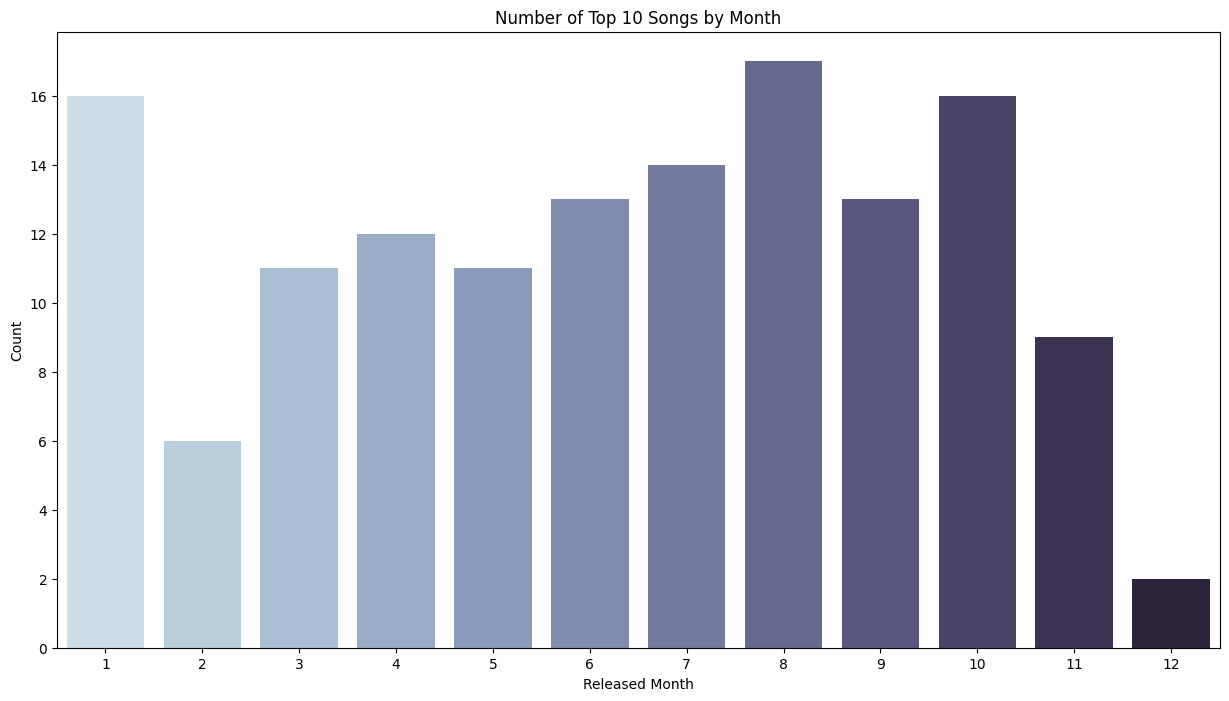

In [61]:
#Counting occurrences of each month
month_counts = top_10['released_month'].value_counts()

# plotting number of released songs per month for the top 10s
plt.figure(figsize=(15, 8))
sns.barplot(x=month_counts.index, y=month_counts.values, palette='ch:s=.25,rot=-.25')

plt.xlabel('Released Month')
plt.ylabel('Count')
plt.title('Number of Top 10 Songs by Month')
plt.show()

Most songs that have made it to the top 10 were released in January, August or October. Reason for this can be seasonality like summer and vacation time. Additionally, music award season is in August and October.

# Correlation among musical features

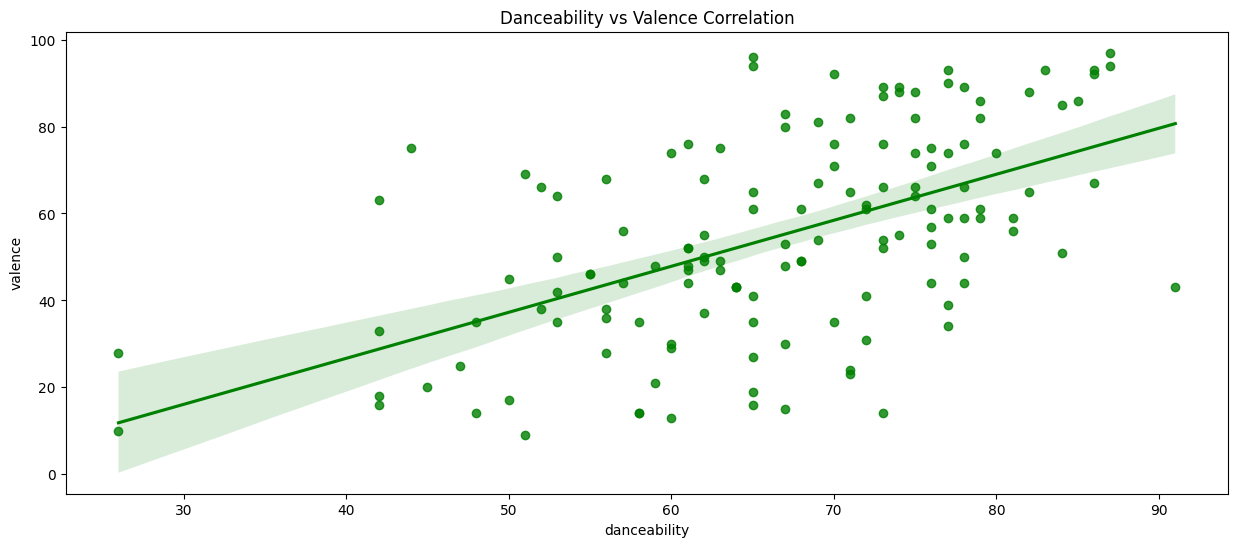

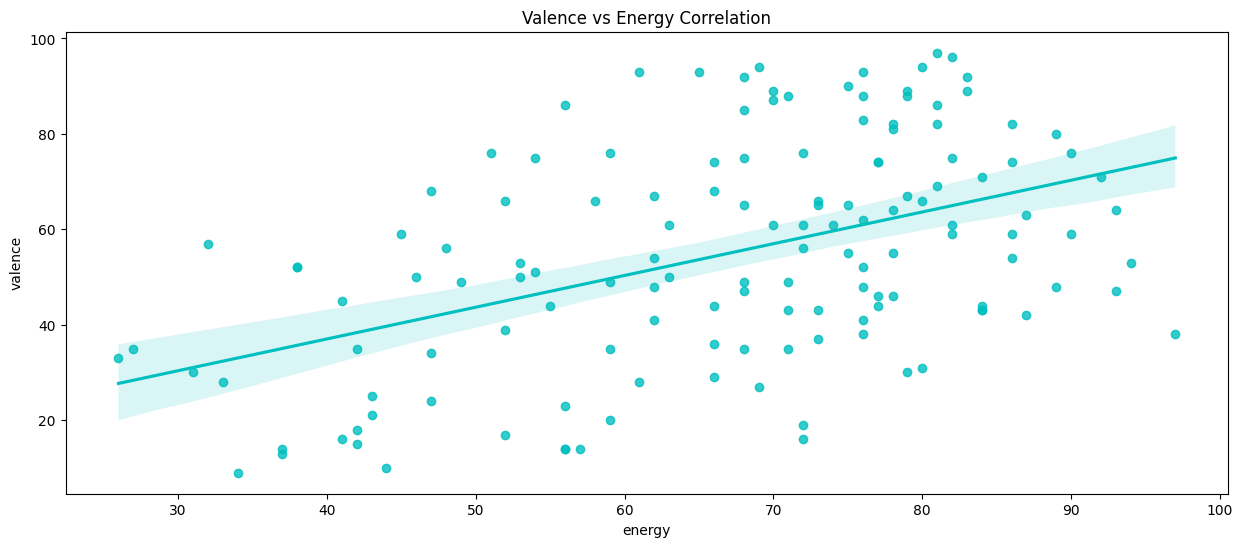

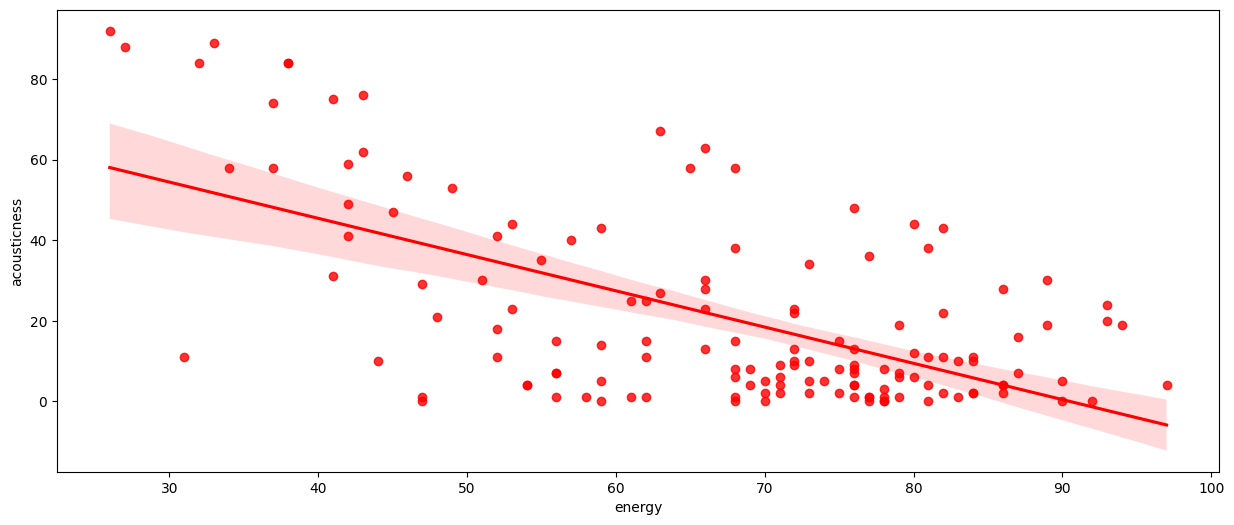

In [64]:
plt.figure(figsize=(15,6))
dnc_val = sns.regplot(data=top_10, y=top_10['valence'], x=top_10['danceability'], color='g')
dnc_val.set_title('Danceability vs Valence Correlation')
plt.show()

plt.figure(figsize=(15,6))
ene_val = sns.regplot(data=top_10, y=top_10['valence'], x=top_10['energy'], color='c')
ene_val.set_title('Valence vs Energy Correlation')
plt.show()


plt.figure(figsize=(15,6))
acc_ene = sns.regplot(data=top_10, y=top_10['acousticness'], x=top_10['energy'], color='r')
dnc_val.set_title('Acousticness vs Energy Correlation')
plt.show()

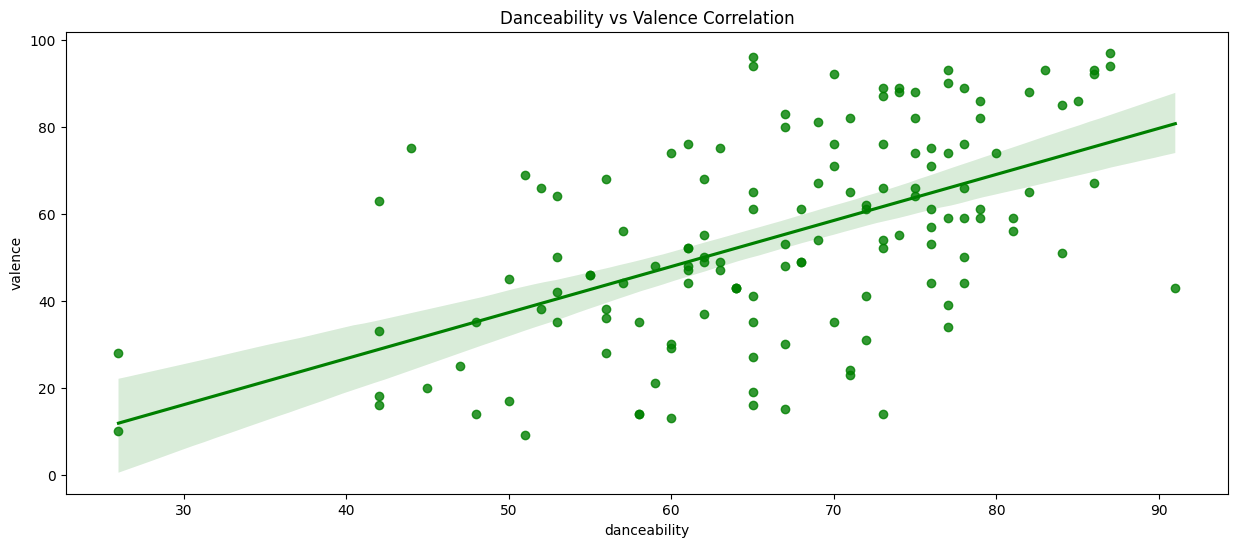

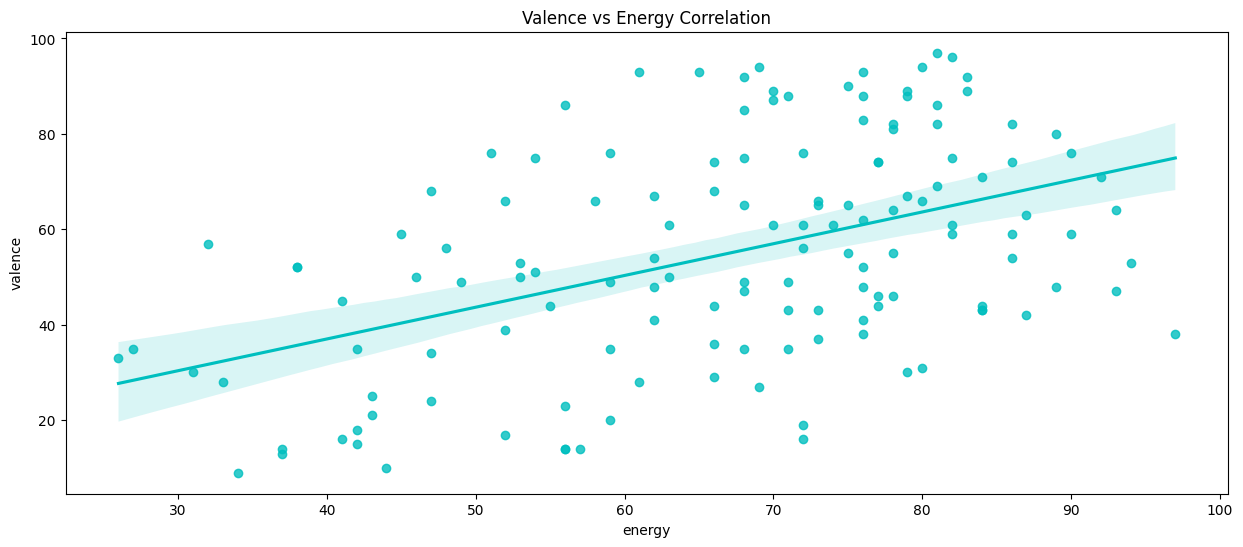

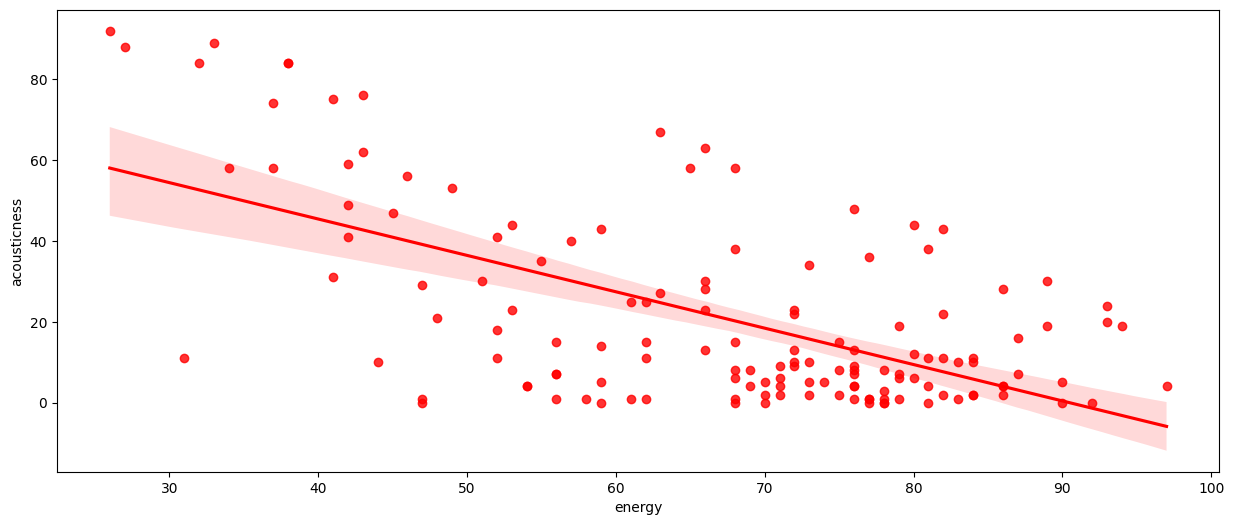

In [65]:
plt.figure(figsize=(15,6))
dnc_val = sns.regplot(data=top_10, y=top_10['valence'], x=top_10['danceability'], color='g')
dnc_val.set_title('Danceability vs Valence Correlation')
plt.show()

plt.figure(figsize=(15,6))
ene_val = sns.regplot(data=top_10, y=top_10['valence'], x=top_10['energy'], color='c')
ene_val.set_title('Valence vs Energy Correlation')
plt.show()


plt.figure(figsize=(15,6))
acc_ene = sns.regplot(data=top_10, y=top_10['acousticness'], x=top_10['energy'], color='r')
dnc_val.set_title('Acousticness vs Energy Correlation')
plt.show()

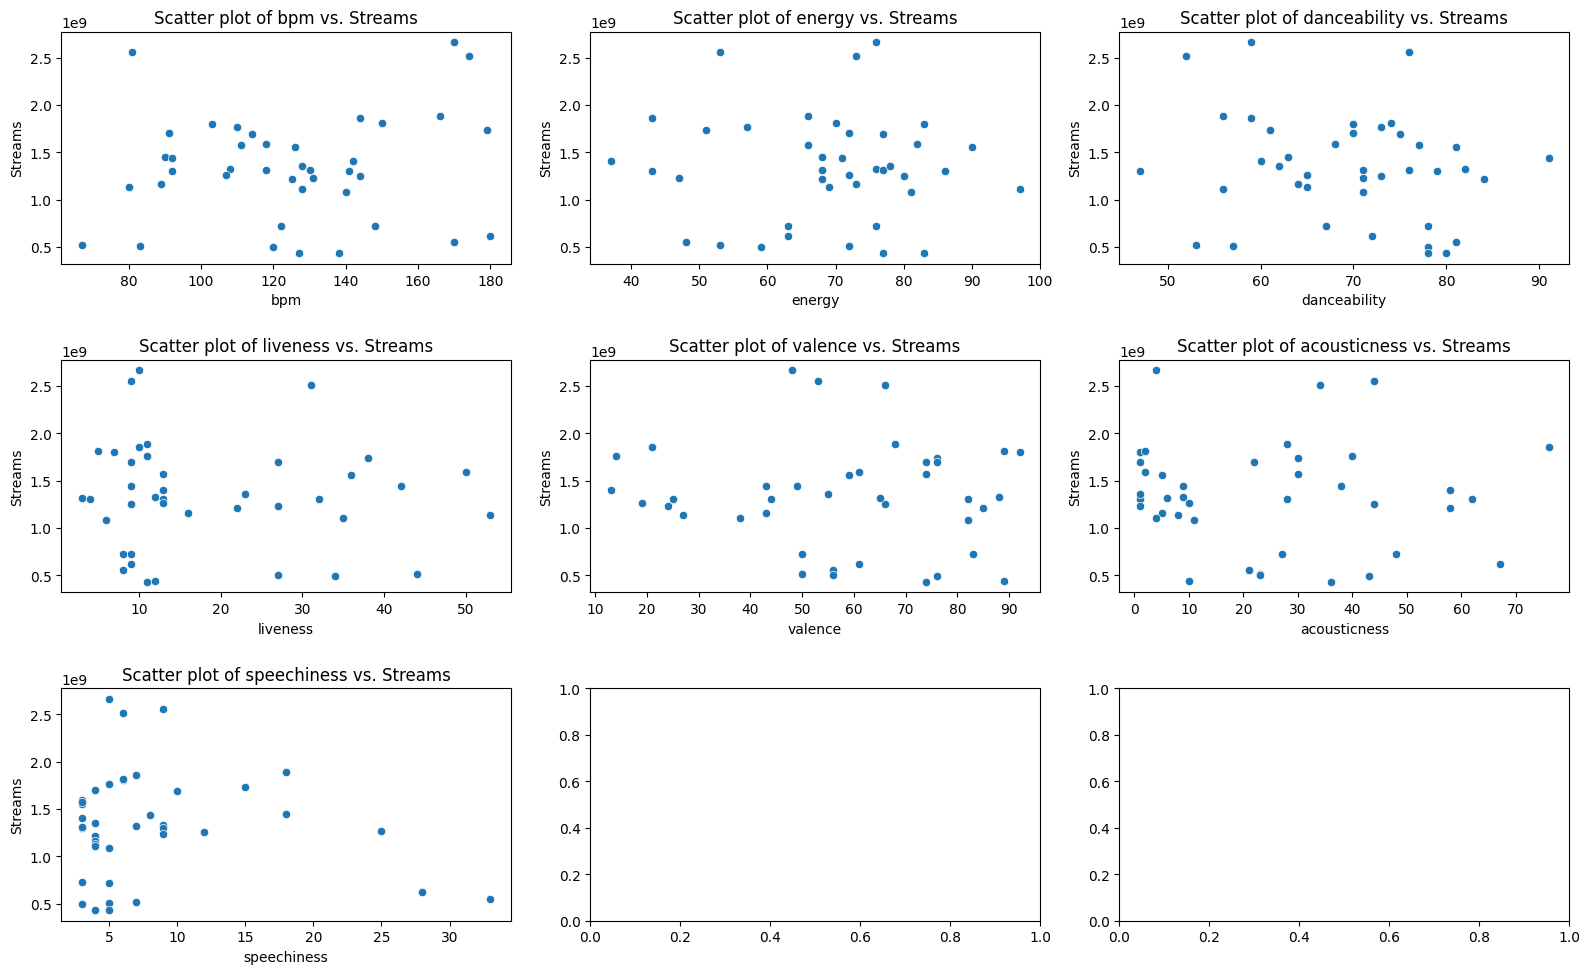

In [66]:
#plotting the correlation of different musical features to number of streams

numerical_columns = ['bpm', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']

# Create a larger grid with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(16, 10))

# Loop over numerical columns and populate the subplots
for i, col in enumerate(numerical_columns):
    sns.scatterplot(data=top_10_songs_2020_2023, x=col, y='streams', ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Scatter plot of {col} vs. Streams')
    axes[i // 3, i % 3].set_xlabel(col)
    axes[i // 3, i % 3].set_ylabel('Streams')

plt.tight_layout()
plt.show()

Finding: A high number of streams is considered a success. Aim was to find out which features are likely to lead to a high number of streams.
Conclusion: The result showe no clear trend of a particular feature correlated to an increase in streans.

Available plot options:
1. Violin Plot
2. Histogram
3. Correlation Heatmap
4. Choropleth Map
5. Line Plot
Enter the number of the plot you want to create: 1
Enter the columns to plot (comma-separated, no space): bpm,danceability,valence,energy,acousticness,liveness,speechiness
Enter the title for the plot: Density of musical features among top 10 songs
Enter the xlabel for the plot: Song Title
Enter the ylabel for the plot: Frequency


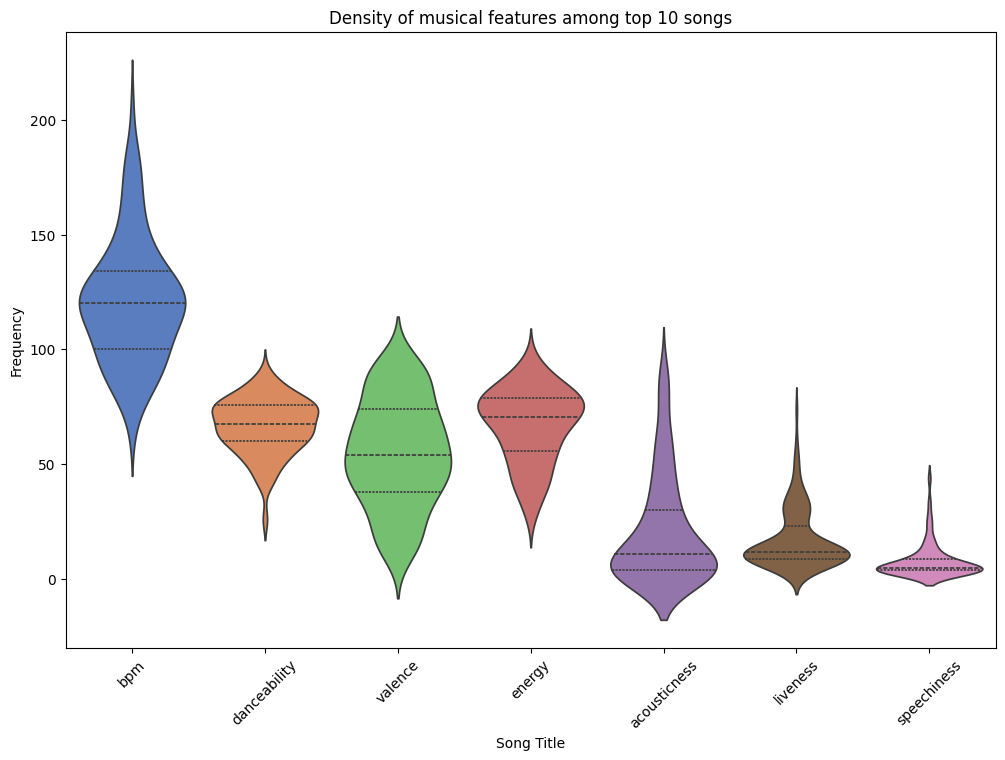

In [68]:
top_10_plot = Plotting(top_10)
top_10_plot.select_plot()

Findings/Conclusion:
To understand which features a song needs in order to be most likely to be among the top 10 songs, we are looking at the distribution of values in each musical feature. The bpm should be around 125, dancabilits around 75, valance has less predictive power as the variety in values is quite scattered. Only a small number of songs with high acoustics made it to the top 10. Same with liveness. The speachness values are also densly packed with a few exceptions.
